<a href="https://colab.research.google.com/github/CallMeL/OML-hw/blob/master/subgradient_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise sheet 7

**Please turn in your exercises by Monday, January 13sth.**

## Task 1: Covergence

Provide a good intuition why the convergence rate of the subgradient method is $O(1/\varepsilon^2)$.


## Task 2: Gradient is sub-gradient

Prove the following lemma.

**Lemma**

If $f: \mathbb{R}^n\rightarrow \mathbb{R}$ is convex and differentiable, then $\forall x, \partial f(x) =\{\nabla f(x)\}$.

## Task 3: Convexity

Prove the following lemma.

**Lemma**

A function $f: D \rightarrow \mathbb{R}$, $D \subseteq \mathbb{R}^d$ is convex if and only if $D$ is convex and $\forall x \in D$, $\partial f(x) \neq \emptyset$.

## Task 4: Smoothing

You can write many convex, not necessarily differentiable function as
$$
f(x) = \max_{i} f_i(x), \quad 1\leq i\leq k
$$
for $k$ convex, differentiable functions $f_i$. One can "smooth" function $f$ by replacing $\max$ with a realsoftmax/logsumexp, i.e.,
$$
g(x) = \frac{1}{M}\log\left(\sum_{i=1}^n \exp(M\cdot f_i(x))\right)
$$
for a fixed parameter $M > 0$. The parameter $M$ controls how close $g$ is to $f$, i.e., how "smooth" the approximation $g$ is.

Such a smoothing is a general way of turning any non-differentiable convex function into a differentiable function. If one does this, one can run Nesterov's gradient method on the resulting smooth function and it will take $O(1/\varepsilon)$ many iterations to reach an absolute error of $\varepsilon$ even on functions that are not necessarily strongly convex. Doesn't such an approach violate the lower bound of $O(1/\varepsilon^2)$ for non-differentiable convex functions that are not necessarily strongly convex?

**Answer:**

No, this approach does not violate the lower bound of $O(1/\varepsilon^2)$ for non-differentiable convex functions.

The reason is that the smoothed function $g$ is not actually the original non-differentiable function $f$. Instead, it is an approximation to $f$ that becomes arbitrarily close to $f$ as $M$ becomes large. This means that the convergence rate of $g$ to $f$ is not the same as the convergence rate of Nesterov's gradient method to $g$.


In other words, the smoothing technique allows us to use Nesterov's gradient method to optimize non-differentiable convex functions more efficiently.However, this does not mean that we can overcome the fundamental limitations of non-differentiable optimization.
      

## Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def contour_map(f, xb=(-1, 1), yb=(-1, 1), ax=None):
    if ax is None:
        ax = plt
    (nx, ny) = (45, 45)
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx, ny)
    ax.contour(xv, yv, zv, 15)


def surface_plot(f, xb=(-1, 1), yb=(-1, 1)):
    (nx, ny) = (45, 45)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x = np.linspace(*xb, nx)
    y = np.linspace(*yb, ny)
    xv, yv = np.meshgrid(x, y)
    X = np.block([[xv.reshape(1, -1)], [yv.reshape(1, -1)]]).T
    zv = np.fromiter((f(x) for x in X), dtype=np.double)
    zv = zv.reshape(nx, ny)
    ax.plot_surface(xv, yv, zv, cmap=cm.coolwarm)
    return fig, ax

## Task 5: Smoothing plots

Using the idea from **Task 4**, plot the "smooth" approximation of the following functions.


### ReLU

Plot an approximation from Task 4 for the function
$$
\text{ReLU}(x) = \max(x, 0)
$$
for different values of $M$.


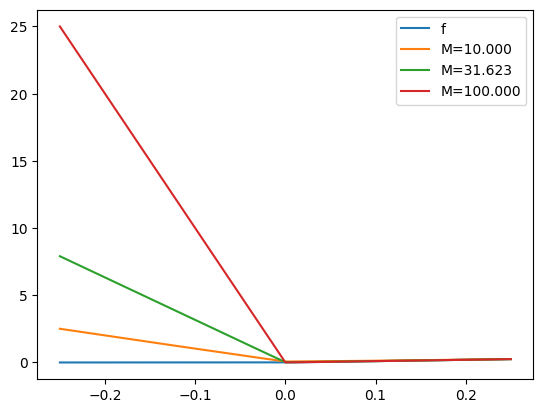

In [5]:
# Values of M
M = np.logspace(1, 2, 3)

def f(x):
    return np.maximum(x, 0)

def f1(x):
    return x

def f2(x):
    return -x

def g(x, M):
    return (1 / M) * np.log(1 + np.exp(M * f1(x))) + np.maximum(0, M * f2(x))

xx = np.linspace(-.25, .25, 1000)
plt.plot(xx, f(xx))
for i in M:
    plt.plot(xx, g(xx, i))
plt.legend(['f'] + [f'M={i:.3f}' for i in M])
plt.show()

### Absolute value

Plot an approximation from Task 4 for the function
$$
\text{abs}(x) = |x|
$$
for different values of $M$.

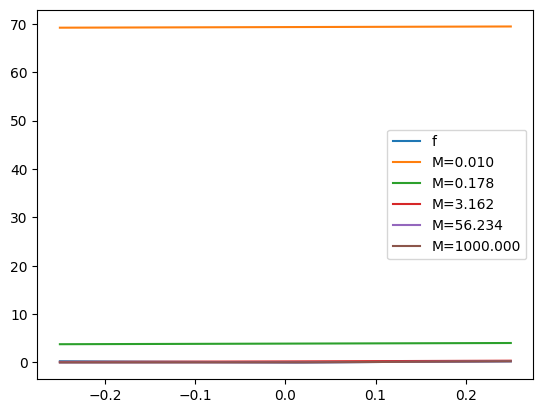

In [4]:
# Values of M
M = np.logspace(-2, 3, 5)

def f(x):
    return np.abs(x)

def f1(x):
    return x

def f2(x):
    return 0

def g(x, M):
    return (1 / M) * np.log(1 + np.exp(M * f1(x))) + np.maximum(0, M * f2(x))

xx = np.linspace(-.25, .25, 1000)
plt.plot(xx, f(xx))
for i in M:
    plt.plot(xx, g(xx, i))
plt.legend(['f'] + [f'M={i:.3f}' for i in M])
plt.show()

## Task 6: Sub-gradient method

Implement the sub-gradient method.
* `x0` is the initial point.
* `f` is the function you are trying to minimize.
* `g` is the subgradient of `f`.

Function `subgradient_path` should return a list of vectors on the path to the minimum.

In [16]:
def subgradient_path(x0, f, g, max_iterations=int(1e5)):
    visited_points = [x0]

    for iteration in range(max_iterations):
        subgradient = g(x0)

        # Check for convergence: stop if the subgradient norm is very small
        if np.linalg.norm(subgradient) < 1e-7:
            break

        # Compute the step size using a diminishing step size formula
        step_size = 1.0 / (np.sqrt(iteration + 1) * np.linalg.norm(subgradient))

        x0 = x0 - step_size * subgradient
        visited_points.append(x0)

    return visited_points


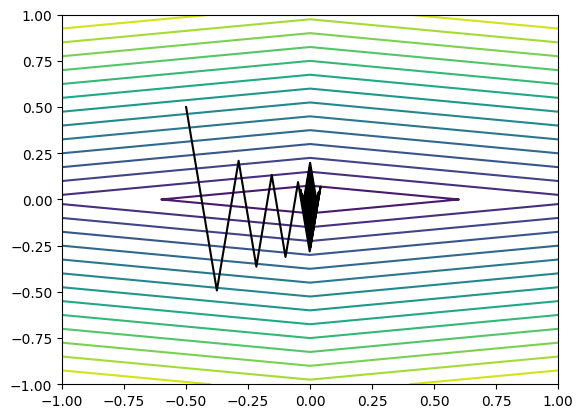

In [17]:
### example
f = lambda x: abs(x[0]) + abs(8 * x[1])
g = lambda x: np.sign(x) * [1, 8]

x0 = np.array([-0.5, 0.5])
xs = subgradient_path(x0, f, g)
xs = np.array(xs)

contour_map(f)
plt.plot(xs[:, 0], xs[:, 1], "-k")
plt.show()

### Robust regresssion

Finish the gradient of the function
$$
f(w) = \frac{1}{n}\left\|Xw - y\right\|_1
$$
run the sub-gradient method on it, and plot the function over time.

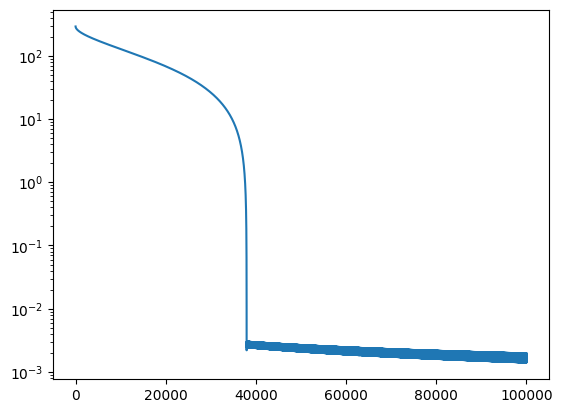

In [20]:
from sklearn.datasets import make_regression
from scipy.optimize import minimize

def f(w):
    return np.linalg.norm(X @ w - y, 1) / len(X)

def g(w):
    return X.T @ np.sign(X@w - y) / len (X)

X, y = make_regression(
    n_samples=1000,
    n_features=100,
    n_informative=40,
    random_state=0
)
x0 = np.zeros(100)
xs = subgradient_path(x0, f, g)
xs = np.array(xs)

plt.semilogy(list(range(len(xs))), [f(x) for x in xs])
plt.show()

### Linear regression with $\mathcal{l}_1$ regularization

Finish the gradient of the function
$$
f(w) = \frac{1}{n}\left\|Xw - y\right\|_2^2 + \|w\|_1,
$$
run the sub-gradient method on it, and plot the function over time.

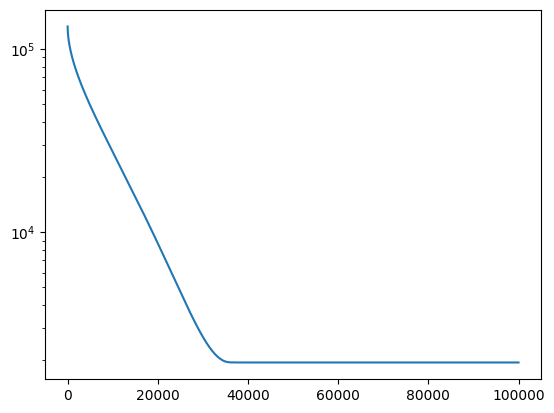

In [21]:
from sklearn.datasets import make_regression

def f(w):
    return np.linalg.norm(X @ w - y) ** 2 / len(X) + np.linalg.norm(w, 1)

def g(w):
    return 2 * X.T @ (X @ w - y) / len(X) + np.sign(w)

X, y = make_regression(
    n_samples=1000,
    n_features=100,
    n_informative=40,
    random_state=0
)
x0 = np.zeros(100)

xs = subgradient_path(x0, f, g)
xs = np.array(xs)

plt.semilogy(list(range(len(xs))), [f(x) for x in xs])
plt.show()

### Logistic regression with $\mathcal{l}_1$ regularization

Finish the gradient of the function
$$
f(w) = \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i \cdot x_i^\top w)) + \|w\|_1
$$
run the sub-gradient method on it, and plot the function over time.

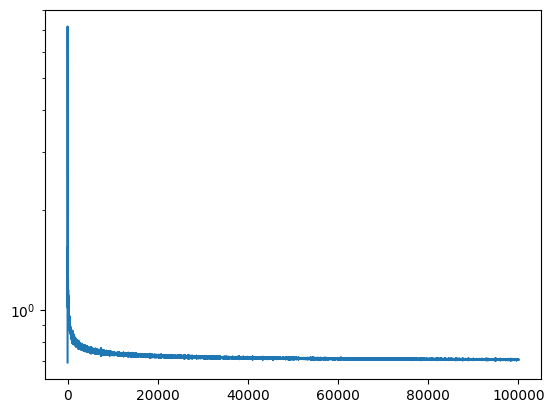

In [22]:

from sklearn.datasets import make_classification
from scipy.optimize import minimize

def logistic_function(x):
    return 1.0 / (1.0 + np.exp(-x))

def f(w):
  return np.log(1. + np.exp(-y * X.dot(w))).mean() + np.linalg.norm(w, 1)

def g(w):
  sig = np.exp(-y * X.dot(w))
  return - X.T.dot(sig * y / (sig + 1.)) / X.shape[0] + np.sign(w)

X, y = make_classification(
    n_samples=1000,
    n_features=80,
    n_informative=40,
    n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0.1,
    random_state=0
)

x0 = np.zeros(80)
xs = subgradient_path(x0, f, g)
xs = np.array(xs)


plt.semilogy(list(range(len(xs))), [f(x) for x in xs])
plt.show()